In [1]:
#importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import cv2
from scipy.spatial import distance

## **MASK DETECTİON**

In [2]:
#providing paths

mask_path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask"
no_mask_path = "../input/human-faces/Humans"

In [3]:
img_mask = []
target_mask = []
for i in os.listdir(mask_path):
    pic = os.path.join(mask_path + "/", i)
    img_mask.append(pic)
    target_mask.append("mask")   

img_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path): #adding images path in a list
    pic = os.path.join(no_mask_path + "/", i)
    img_no_mask.append(pic)
    target_no_mask.append("without_mask")

mask = pd.DataFrame()
mask["image"] = img_mask
mask["target"] = target_mask

no_mask = pd.DataFrame()
no_mask["image"] = img_no_mask
no_mask["target"] = target_no_mask

data = pd.concat([mask, no_mask], axis = 0, ignore_index = True)
data = shuffle(data)
data

,image,target
4430,../input/face-mask-12k-images-dataset/Face Mas...,mask
5846,../input/human-faces/Humans/1 (6966).jpg,without_mask
11204,../input/human-faces/Humans/1 (3914).jpg,without_mask
816,../input/face-mask-12k-images-dataset/Face Mas...,mask
5871,../input/human-faces/Humans/1 (4219).jpg,without_mask
...,...,...
11032,../input/human-faces/Humans/1 (3868).jpg,without_mask
7862,../input/human-faces/Humans/1 (1350).jpg,without_mask
9051,../input/human-faces/Humans/1 (2837).jpg,without_mask
5425,../input/human-faces/Humans/1 (3854).jpg,without_mask


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

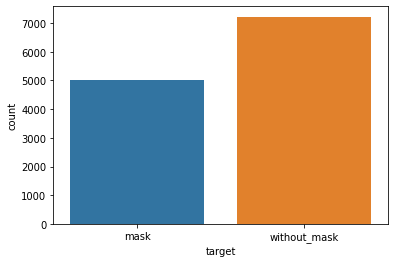

In [4]:
sns.countplot(data["target"])

Maskeli ve maskesiz olan fotoğraflardan birer örneğe göz atalım.

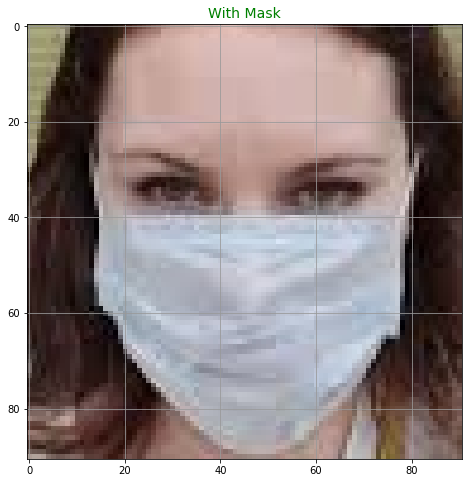

In [5]:
plt.figure(figsize=(12,8))

img = load_img(mask["image"][8])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

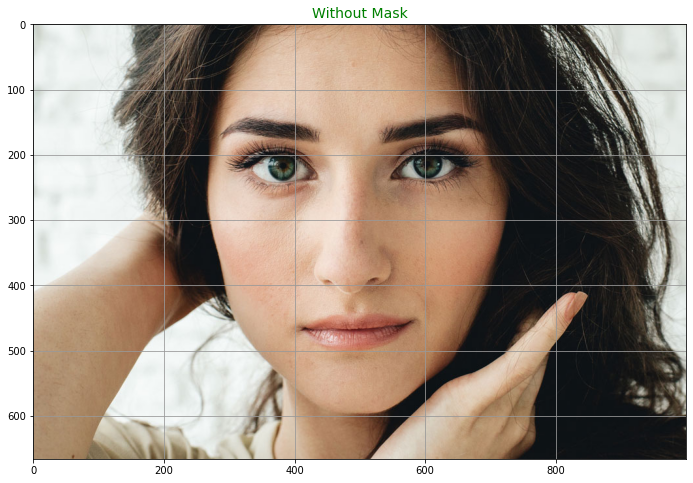

In [6]:
plt.figure(figsize=(12,8))

img = load_img(no_mask["image"][750])
plt.imshow(img)
plt.title("Without Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

In [7]:
train = data.iloc[0:10000, ]
val = data.iloc[10001:11001, ]
test = data.iloc[11002:, ]

In [8]:
print("Train Seti:","\n",train["target"].value_counts(),"\n""Validation Seti: ","\n", val["target"].value_counts(), "\n"
      "Test Seti: ", "\n",test["target"].value_counts())

Train Seti: 
 without_mask    5866
mask            4134
Name: target, dtype: int64 
Validation Seti:  
 without_mask    601
mask            399
Name: target, dtype: int64 
Test Seti:  
 without_mask    750
mask            467
Name: target, dtype: int64


In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

train_generator = train_datagen.flow_from_dataframe(dataframe = train,
                                                    x_col = "image",
                                                    y_col = "target",
                                                    target_size = (150, 150),
                                                    batch_size = 32,
                                                    class_mode = "binary")

val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_dataframe(dataframe = val,
                                                x_col = "image",
                                                y_col = "target",
                                                target_size = (150, 150),
                                                batch_size = 32,
                                                class_mode = "binary")


test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                  x_col = "image",
                                                  y_col = "target",
                                                  target_size = (150, 150),
                                                  class_mode = "binary",
                                                  batch_size = 32)

Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.


In [10]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["acc"])

In [12]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=len(val_generator)//32)

Epoch 1/50
9/9 [==============================] - 33s 2s/step - loss: 0.7592 - acc: 0.4426 - val_loss: 0.6623 - val_acc: 0.5625
Epoch 2/50
9/9 [==============================] - 22s 2s/step - loss: 0.6930 - acc: 0.5474 - val_loss: 0.5563 - val_acc: 0.8125
Epoch 3/50
9/9 [==============================] - 24s 3s/step - loss: 0.6315 - acc: 0.6206 - val_loss: 0.5863 - val_acc: 0.6875
Epoch 4/50
9/9 [==============================] - 21s 2s/step - loss: 0.5939 - acc: 0.7015 - val_loss: 0.5610 - val_acc: 0.7500
Epoch 5/50
9/9 [==============================] - 21s 2s/step - loss: 0.5706 - acc: 0.7572 - val_loss: 0.4673 - val_acc: 0.8438
Epoch 6/50
9/9 [==============================] - 20s 2s/step - loss: 0.5484 - acc: 0.7483 - val_loss: 0.4919 - val_acc: 0.8125
Epoch 7/50
9/9 [==============================] - 21s 2s/step - loss: 0.4751 - acc: 0.8044 - val_loss: 0.4763 - val_acc: 0.7812
Epoch 8/50
9/9 [==============================] - 21s 2s/step - loss: 0.5004 - acc: 0.7802 - val_loss: 0

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9/9 [==============================] - 20s 2s/step - loss: 0.3685 - acc: 0.8982 - val_loss: 0.2676 - val_acc: 0.8750
Epoch 15/50
9/9 [==============================] - 22s 2s/step - loss: 0.4031 - acc: 0.8672 - val_loss: 0.2602 - val_acc: 0.9062
Epoch 16/50
9/9 [==============================] - 21s 2s/step - loss: 0.3553 - acc: 0.8952 - val_loss: 0.2819 - val_acc: 0.9062
Epoch 17/50
9/9 [==============================] - 21s 2s/step - loss: 0.3270 - acc: 0.9000 - val_loss: 0.1842 - val_acc: 1.0000
Epoch 18/50
9/9 [==============================] - 21s 2s/step - loss: 0.3434 - acc: 0.8930 - val_loss: 0.2612 - val_acc: 0.9062
Epoch 19/50
9/9 [==============================] - 20s 2s/step - loss: 0.3508 - acc: 0.8797 - val_loss: 0.2846 - val_acc: 0.9062
Epoch 20/50
9/9 [==============================] - 21s 2s/step - loss: 0.3128 - acc: 0.9248 - val_loss: 0.1558 - val_acc: 0.9688
Epoch 21/50
9/9 [==============================] - 21s 2s/step - loss: 0.3343 - acc: 0.8936 - val_loss: 0.275

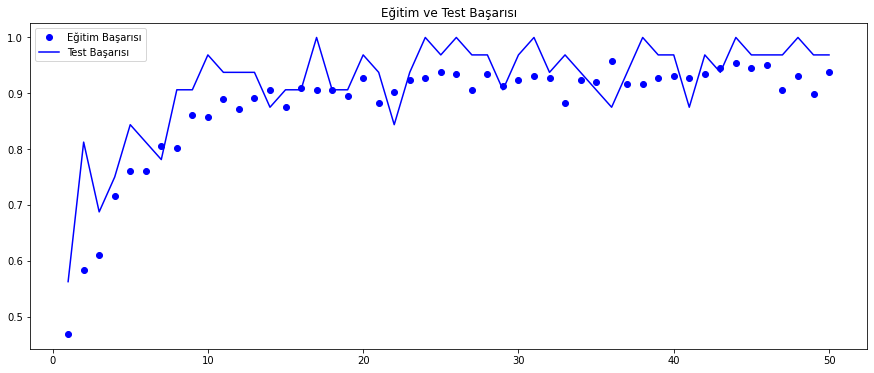

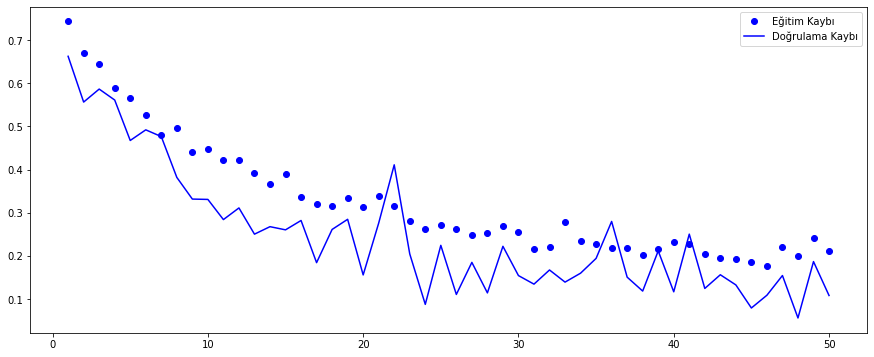

In [13]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (15, 6))

plt.plot(epochs, acc, "bo", label = "Eğitim Başarısı")
plt.plot(epochs, val_acc, "b", label = "Test Başarısı")
plt.title("Eğitim ve Test Başarısı")
plt.legend()

plt.figure(figsize = (15, 6))

plt.plot(epochs, loss, "bo", label = "Eğitim Kaybı")
plt.plot(epochs, val_loss, "b", label = "Doğrulama Kaybı")
plt.legend()

plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_generator, steps = 9)
print("Test ACC: ", round(test_acc, 2))

9/9 [==============================] - 18s 2s/step - loss: 0.1109 - acc: 0.9618
Test ACC:  0.96


Test doğruluk oranı yukarıdaki çıktı.

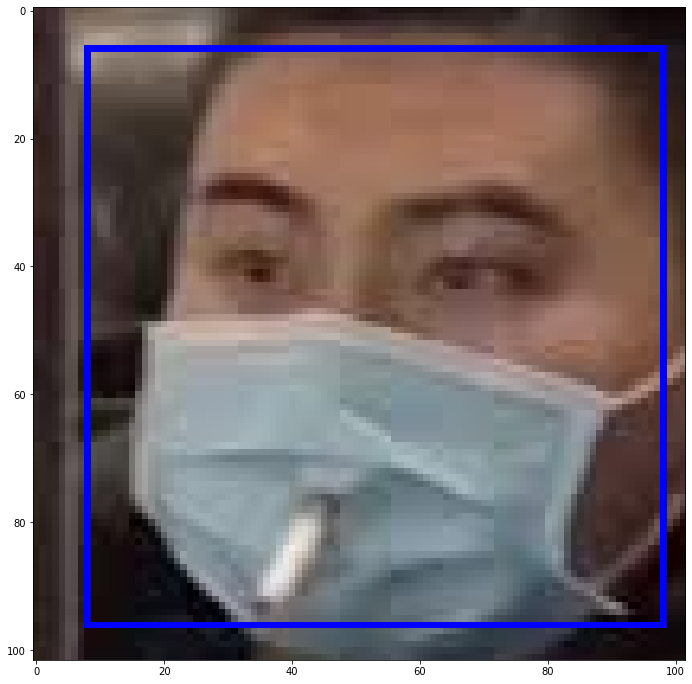

In [15]:
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')
img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/1058.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [16]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/1058.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0
model.predict(sample_mask_img)

array([[0.12870675]], dtype=float32)

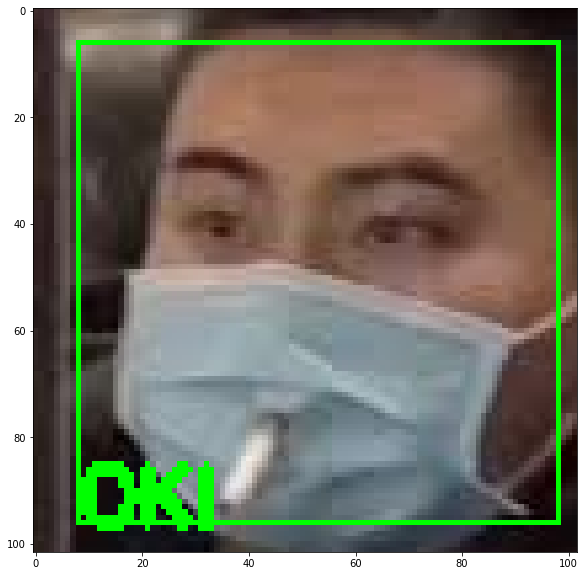

In [17]:
mask_label = {0:'Mask Found!',1:'No Mask Found'}
dist_label = {0:(0,255,0),1:(255,0,0)}
MIN_DISTANCE = 0

if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y+90), cv2.FONT_HERSHEY_SIMPLEX,0.5,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("Yüz yok!")

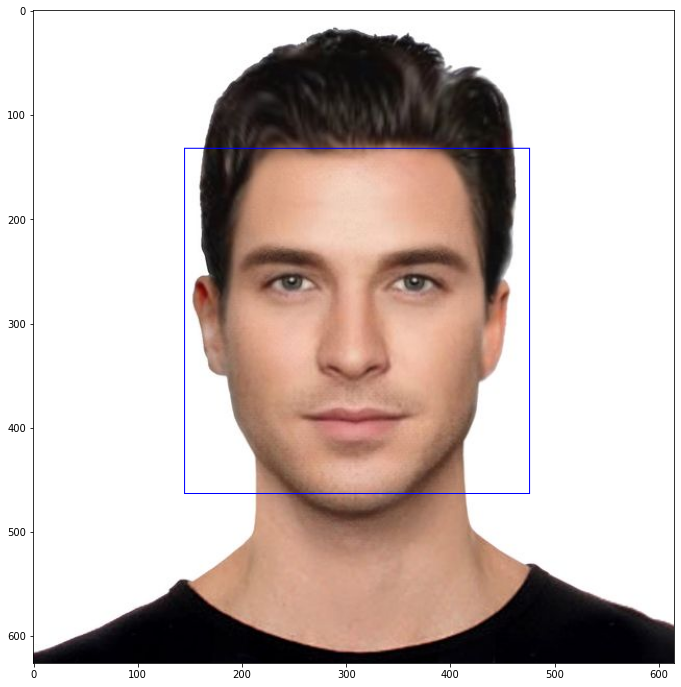

In [18]:
img = cv2.imread('../input/human-faces/Humans/1 (1093).jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 

for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [19]:
sample_mask_img = cv2.imread('../input/human-faces/Humans/1 (1092).jpg')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0
model.predict(sample_mask_img)

array([[0.9794678]], dtype=float32)

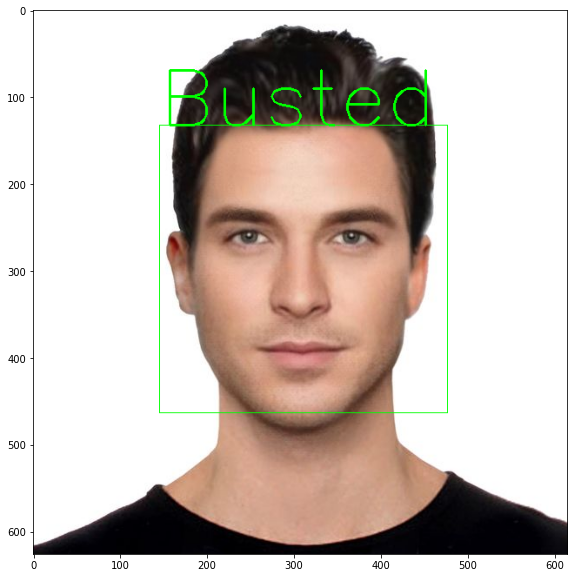

In [20]:
if len(faces)>=1:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,mask_label[round(mask_result[0][0])],(x, y), cv2.FONT_HERSHEY_SIMPLEX,3,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No image found!")